In [21]:
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import pickle
import math as m
import os
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl


#globally change font size for plots
plt.rcParams['font.size'] =17
plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'


from residual_plot import residual_plot

In [60]:
outfile = 'HARPS2.3.1_ready_for_TF_records.npz'#'
npzfile = np.load(outfile) 
npzfile.files

npz_data = {"BJD": npzfile["BJD"],
           "vrad_star": npzfile["vrad_star"],
           "CCF_normalized_list_cutoff": npzfile["CCF_normalized_list_cutoff"].tolist()}
npz_df = pd.DataFrame(data=npz_data)

df_sorted_npz = npz_df.sort_values(by=['BJD'])

In [64]:
results_cnn = pd.read_csv('Results_colab/inject_recov_0.3ms250d_10d_allevals_preds_CNN_02_22_2022.csv')
results_cnn["BJD"] = results_cnn["BJD"] + 2457222.995875525
results_cnn

df_sorted = results_cnn.sort_values(by=['BJD'])

In [77]:
df_sorted

,labels,preds,BJD
0,2.246346,2.080028,2.457223e+06
1,3.583019,3.467218,2.457233e+06
2,3.758775,4.780319,2.457234e+06
3,3.926729,4.364743,2.457235e+06
4,5.370801,5.611648,2.457236e+06
...,...,...,...
523,-2.120353,-3.033572,2.458308e+06
524,-1.578788,-2.340885,2.458311e+06
525,-1.029903,-1.559247,2.458313e+06
526,-1.147690,-0.798139,2.458314e+06


0.0 1.0


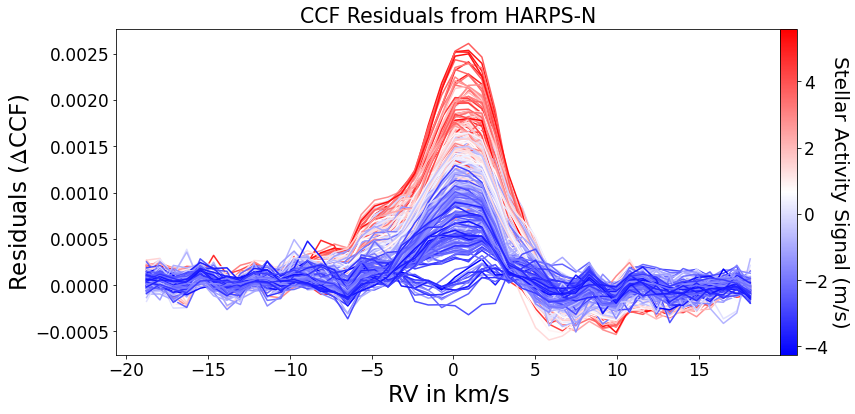

In [23]:
rv_data = np.linspace(-19.58, 19.78, 49)

#residual_plot(npzfile['vrad_star'], rv_data, npzfile['zero_shifted_CCF_list'], 484, 'Original') #

residual_plot(npzfile['vrad_star']*1000, rv_data[1:47], npzfile['CCF_normalized_list_cutoff'], 484, 'CCF Residuals from HARPS-N')


In [24]:
len(npzfile['CCF_normalized_list_cutoff'])

528

0.0 1.0


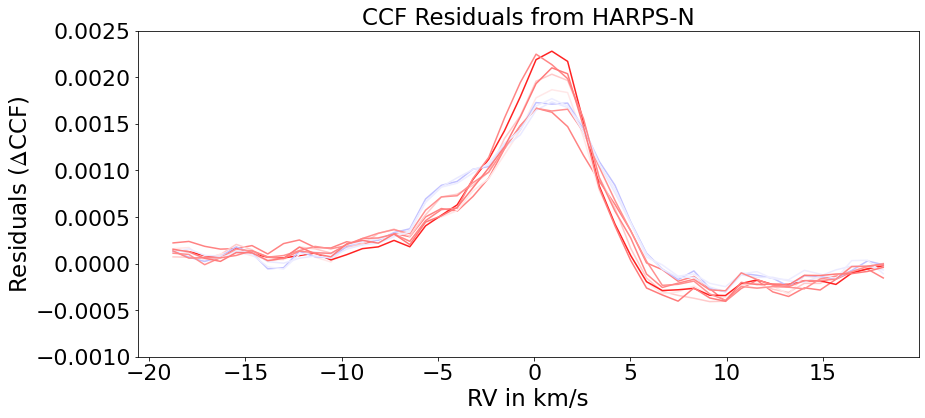

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))


# plot ccf frame
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

rv_list = npzfile['vrad_star']*1000
min_rv = np.min(rv_list)
max_rv = np.max(rv_list)
cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
print(np.min(cscale_residuals), np.max(cscale_residuals))

col = plt.cm.jet([0.25,0.75])
n = len(npzfile['CCF_normalized_list_cutoff'])
colors = plt.cm.bwr(cscale_residuals)

ax.set_xlabel('RV in km/s', size=23)
ax.set_ylabel('Residuals ($\Delta$CCF)', size=23)
ax.set_title("CCF Residuals from HARPS-N", size =23)


ax.tick_params(axis='x', labelsize= 22) #to Set Matplotlib Tick Labels Font Size
ax.tick_params(axis='y', labelsize= 22)

def plot_residuals(number):
        # Data for plotting
        #rv_data = np.linspace(-20, 20, 161)

        #ax.plot(rv_data,CCF_data1_list[number]-CCF_data_zero,  color = colors[number])
        ax.plot(rv_data[1:47], npzfile['CCF_normalized_list_cutoff'][number]-npzfile['CCF_normalized_list_cutoff'][484], color = colors[number])
        #ax.set_xlabel('RV in km/s', size=20)
        #ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
        #ax.set_title("Old CCF Residuals from HARPS-N", size =20)

        # IMPORTANT ANIMATION CODE HERE
        # Used to keep the limits constant
        ax.set_ylim(-0.001, 0.0025)

        # Used to return the plot as an image rray
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image


a_range = np.arange(0, 10)#len(npzfile['CCF_normalized_list_cutoff']))
#a_range = np.delete(a_range, 10)#484)
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./CCF_preds_H-N_2.3.2.gif', [plot_residuals(i) for i in a_range], fps=10)

In [43]:
def wrapper(rv_list, x_axis, ccfs_of_interest, num_ref_ccf, plot_title):

    # create color scheme
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.title(plot_title)
    # make color bar
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=(min_rv - np.median(rv_list)), vmax=(max_rv - np.median(rv_list)))
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="vertical", pad=-0.0001)
    cb.set_label(label='Stellar Activity Signal (m/s)', size=20, rotation=270, labelpad=20)
    plt.xlabel("RV in km/s", size=23)
    plt.ylabel("Residuals ($\Delta$CCF)", size=23)


    def residual_plot_anim(number):#, x_axis, ccfs_of_interest, num_ref_ccf):
        # Create the residual plot by looping through the list of CCFs ordered by date
        if num_ref_ccf == "median":
            plt.plot(x_axis, ccfs_of_interest[number] - np.median(list(ccfs_of_interest), axis=0), color=colors[number])
        else:
            if i != num_ref_ccf:
                plt.plot(x_axis, ccfs_of_interest[number] - np.array(ccfs_of_interest[num_ref_ccf]), color=colors[number])

        # IMPORTANT ANIMATION CODE HERE
        # Used to keep the limits constant
        ax.set_ylim(-0.0006, 0.0027)

        # Used to return the plot as an image rray
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image


    a_range = np.arange(0, len(npzfile['CCF_normalized_list_cutoff']))
    a_range = np.delete(a_range, 484)
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    for i in a_range:
        print(i)
    imageio.mimsave('./CCF_preds_H-N_2.3.2.gif', [residual_plot_anim(i) for i in a_range], fps=1)     
    

0.0 1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

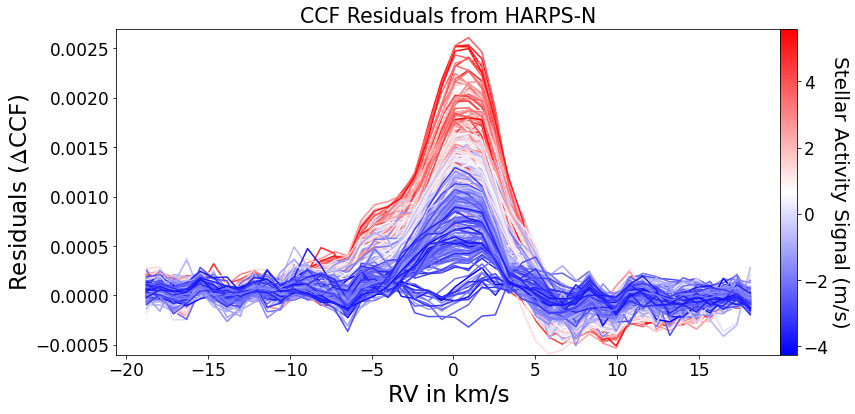

In [44]:
wrapper(npzfile['vrad_star']*1000, rv_data[1:47], 
        npzfile['CCF_normalized_list_cutoff'], 484,
        'CCF Residuals from HARPS-N')

In [65]:
for num in range(0, len(df_sorted["BJD"])):
    print(df_sorted["BJD"][num], df_sorted_npz['BJD'][num])

2457222.995875525 2457328.048634349
2457232.9921514266 2457333.0378636313
2457233.996867346 2457378.0337799476
2457235.0000087493 2457385.0297949105
2457236.0006648772 2457270.027739038
2457237.0004245513 2457268.9913589023
2457237.9962245696 2457335.0500616515
2457239.0323859924 2457268.015872923
2457239.9771568053 2457368.0183145734
2457242.0329353088 2457386.025749024
2457252.004563498 2457271.0214128126
2457253.9910423034 2457334.0442696535
2457256.0129386657 2457222.995875525
2457257.0298759216 2457237.0004253644
2457260.016665625 2457239.97715949
2457261.0131446593 2457303.0339660184
2457262.0098792785 2457232.9921516497
2457263.0085059875 2457302.037999302
2457264.021514105 2457239.0323848473
2457265.0214454406 2457326.0454837563
2457266.028357672 2457237.9962247657
2457267.035453009 2457304.041222259
2457268.015868353 2457256.0129388543
2457268.9913589233 2457308.011446832
2457270.027739691 2457253.991040223
2457271.021414923 2457261.013146043
2457272.9654456847 2457263.0085062

In [62]:
len(df_sorted["BJD"])

528

In [63]:
len(df_sorted_npz['BJD'])

528

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 18))

col = plt.cm.jet([0.25,0.75])
n = len(CCF_array_all)
colors = plt.cm.bwr(cscale_residuals)

ax[0].set_xlabel('RV in km/s', size=20)
ax[0].set_ylabel('Residuals ($\Delta$CCF)', size=20)
ax[0].set_title("CCF Residuals from HARPS-N", size =20)

# plot rv frame
ax[1].set_ylabel('Predicted Stellar Activity (m/s)', size=22);
ax[1].set_ylim(-5, 7.5)
ax[1].set_title("Model Predicted Stellar Activity", size=24)
x_space = np.linspace(np.min(model_bjds_plot), np.max(model_bjds_plot), 1000)

for index_1 in [0,1]:
    ax[index_1].tick_params(axis='x', labelsize= 22) #to Set Matplotlib Tick Labels Font Size
    ax[index_1].tick_params(axis='y', labelsize= 22)

def plot_residuals(number):
        # Data for plotting
        rv_data = np.linspace(-20, 20, 161)

        #ax.plot(rv_data,CCF_data1_list[number]-CCF_data_zero,  color = colors[number])
        ax[0].plot(rv_data, anim_CCF_array_all[number]-CCF_array_all[544], color = colors[number])
        #ax.set_xlabel('RV in km/s', size=20)
        #ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
        #ax.set_title("Old CCF Residuals from HARPS-N", size =20)

        # IMPORTANT ANIMATION CODE HERE
        # Used to keep the limits constant
        ax[0].set_ylim(-0.001, 0.0025)

        ax[1].errorbar(model_bjds_plot[number], model_preds[number], yerr = np.ones_like(model_preds[number]) * uncertainty_true, fmt = 'o', color = colors[number])
        ax[1].set_ylim(-5, 7.5)
        ax[1].set_xlim(np.min(model_bjds_plot)-10, np.max(model_bjds_plot)+10) 
        # Used to return the plot as an image rray
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image


a_range = np.arange(0, len(anim_CCF_array_all))
a_range = np.delete(a_range, 544)
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./CCF_preds_H-N_scale_x_10fps_color_b.gif', [plot_residuals(i) for i in a_range], fps=10)

In [82]:
def wrapper_two_plots(rv_list, x_axis, ccfs_of_interest, num_ref_ccf, plot_title):

    # create color scheme
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 18))
    ax = axes[0]
    ax.set_title(plot_title)
    ax.set_xlabel('RV in km/s', size=20)
    ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
    
    # make color bar
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=(min_rv - np.median(rv_list)), vmax=(max_rv - np.median(rv_list)))
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="vertical", pad=-0.0001)
    cb.set_label(label='Stellar Activity Signal (m/s)', size=20, rotation=270, labelpad=20)
    
    ax = axes[1]
    ax.set_ylabel('Predicted Stellar Activity (m/s)', size=22);
    ax.set_ylim(-5, 7.5)
    ax.set_title("Model Predicted Stellar Activity", size=24)
    x_space = np.linspace(np.min(df_sorted["BJD"]), np.max(df_sorted["BJD"]), 1000)


    def residual_plot_anim(number):#, x_axis, ccfs_of_interest, num_ref_ccf):
        # Create the residual plot by looping through the list of CCFs ordered by date
        if num_ref_ccf == "median":
            ax = axes[0]
            ax.plot(x_axis, ccfs_of_interest[number] - np.median(list(ccfs_of_interest), axis=0), color=colors[number])
        else:
            if i != num_ref_ccf:
                ax = axes[0]
                ax.plot(x_axis, ccfs_of_interest[number] - np.array(ccfs_of_interest[num_ref_ccf]), color=colors[number])

        # IMPORTANT ANIMATION CODE HERE
        # Used to keep the limits constant
        axes[0].set_ylim(-0.0006, 0.0027)
        
        axes[1].errorbar(df_sorted["BJD"][number], df_sorted["preds"][number], yerr = np.ones_like( df_sorted["preds"][number]) * uncertainty_true, fmt = 'o', color = colors[number])
        axes[1].set_ylim(-5, 7.5)
        axes[1].set_xlim(np.min(df_sorted["BJD"])-10, np.max(df_sorted["BJD"])+10) 

        # Used to return the plot as an image rray
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image


    a_range = np.arange(0, len(npzfile['CCF_normalized_list_cutoff']))
    a_range = np.delete(a_range, 484)
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    for i in a_range:
        print(i)
    imageio.mimsave('./CCF_preds_H-N_2.3.2_preds_v2.gif', [residual_plot_anim(i) for i in a_range], fps=5)     
    

0.0 1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

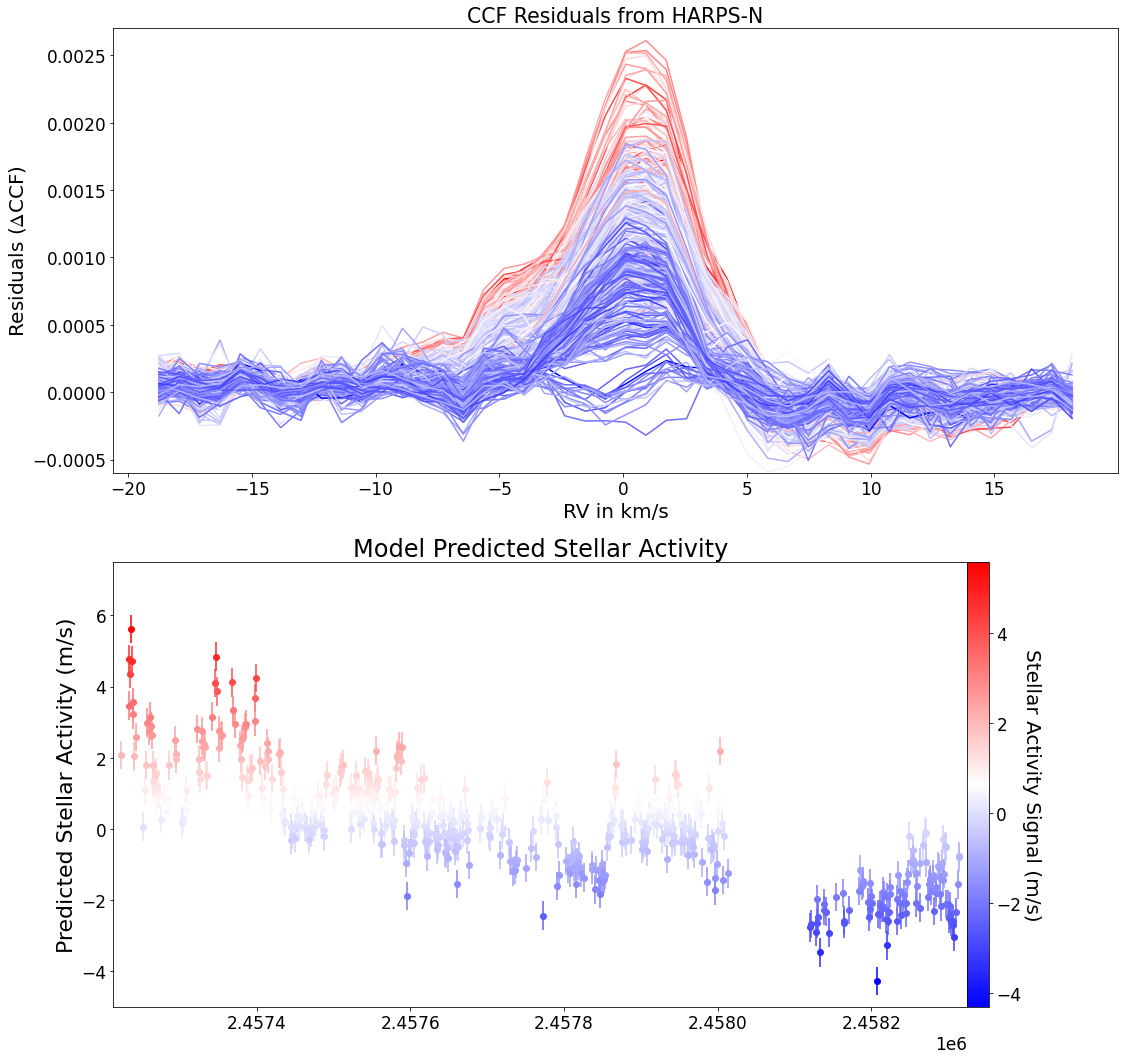

In [83]:
uncertainty_true =0.4

wrapper_two_plots(df_sorted['preds'], rv_data[1:47], 
        npzfile['CCF_normalized_list_cutoff'], 484,
        'CCF Residuals from HARPS-N')

In [78]:
df_sorted

,labels,preds,BJD
0,2.246346,2.080028,2.457223e+06
1,3.583019,3.467218,2.457233e+06
2,3.758775,4.780319,2.457234e+06
3,3.926729,4.364743,2.457235e+06
4,5.370801,5.611648,2.457236e+06
...,...,...,...
523,-2.120353,-3.033572,2.458308e+06
524,-1.578788,-2.340885,2.458311e+06
525,-1.029903,-1.559247,2.458313e+06
526,-1.147690,-0.798139,2.458314e+06
